# Value Investor- A Forecasting Project

Background:


There is a portfolio investment company and they make investments in the emerging markets around the world. Our company profits by investing in profitable companies, buying, holding and selling company stocks based on value investing principles.


Their goal is to establish a robust intelligent system to aid their value investing efforts using stock market data. They make investment decisions and based on intrinsic value of companies and do not trade on the basis of daily market volatility. Their profit realization strategy typically involves weekly, monthly and quarterly performance of stocks they buy or hold.

In [106]:
# Importing libraries relevant to Moving Avg, Exp. Moving Avg, LSTM, and Facebook Prophet

import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import math


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *

from sklearn.preprocessing import  MinMaxScaler
from statsmodels.tsa.api import SimpleExpSmoothing

from prophet import Prophet
from matplotlib.dates import DateFormatter
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [107]:
stock_Data_path=pd.ExcelFile('../Raw Data/2020Q1Q2Q3Q4-2021Q1.xlsx')

In [108]:
sheet_names=stock_Data_path.sheet_names

dfs={}

for sheet_name in sheet_names:
    df=pd.read_excel(stock_Data_path,sheet_name=sheet_name)
    dfs[sheet_name]=df

In [109]:
Consol_data=pd.DataFrame()

for i in range(len(sheet_names)):
    country_name=sheet_names[i].replace(' ','_').split('_-')[0]
    stock_name= sheet_names[i].replace(' ','_').split('-_')[1].split('_(')[0]
    
    country= dfs[sheet_names[i]].iloc[:-1,:].copy()
   
    country['Country'] = country_name
    country['Stock'] = stock_name

    Consol_data = pd.concat([Consol_data, country])

    data_order=['Stock','Country','Date', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'Price']
    Consol_data=Consol_data[data_order]
    Consol_data['Date']=pd.to_datetime(Consol_data['Date'])

# Optional: resetting the index of Consol_data if needed
Consol_data.reset_index(drop=True, inplace=True)

In [110]:
# Converting unit strings into absolute values

def vol_converter(data):
    if data.endswith('M'):
        return float(data.rstrip('M'))*1000000
    elif data.endswith('K'):
        return float(data.rstrip('K'))*1000
    elif data.endswith('-'):
        return float(0)
    else :
        return float(data)
    
Consol_data['Vol.']=Consol_data['Vol.'].apply(vol_converter)  

C:\Users\97158\AppData\Local\Temp\ipykernel_15156\4013710093.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['Date'] = pd.to_datetime(country_data['Date'])
C:\Users\97158\AppData\Local\Temp\ipykernel_15156\4013710093.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['Date'] = pd.to_datetime(country_data['Date'])
C:\Users\97158\AppData\Local\Temp\ipykernel_15156\4013710093.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

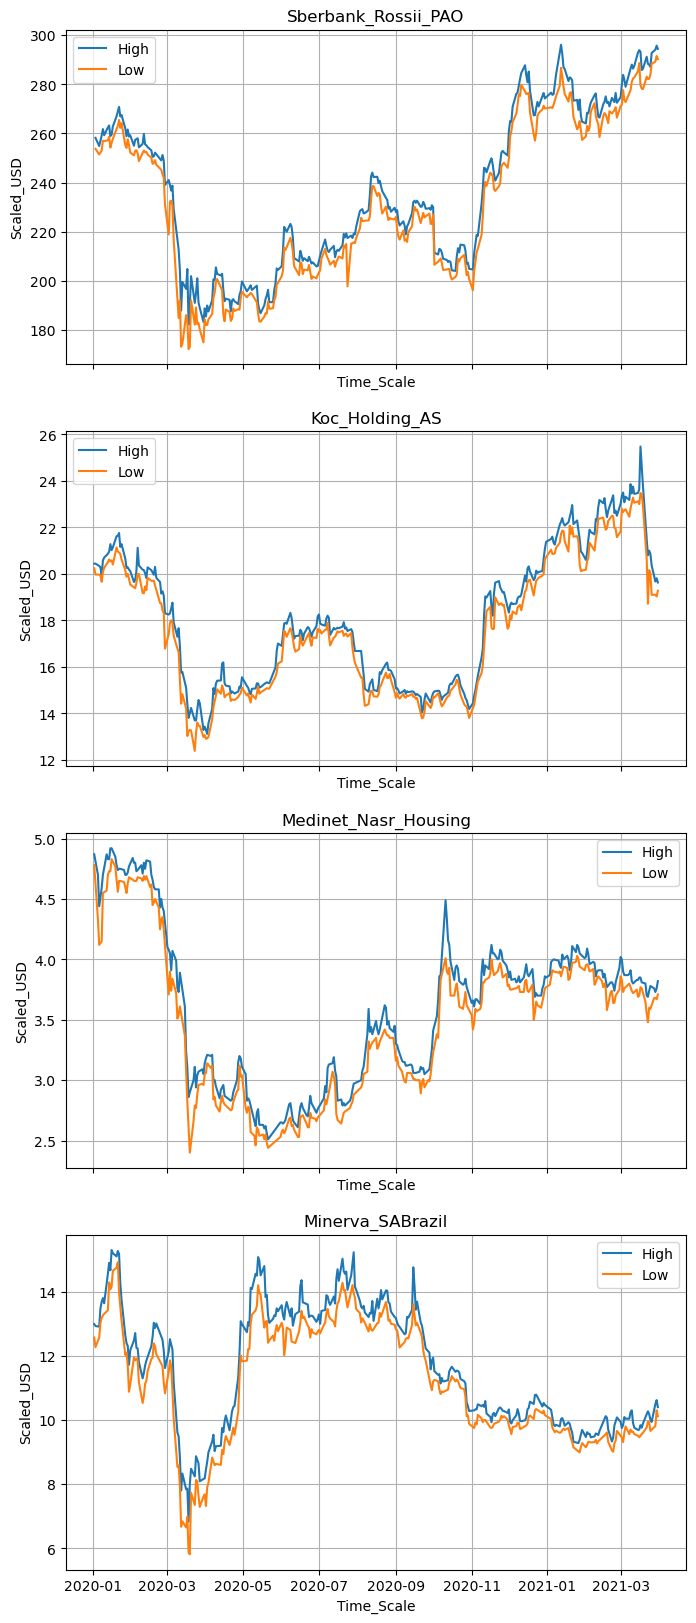

In [111]:
# Plotting charts of raw data for 4 stocks


Stock_list=Consol_data['Stock'].unique()[:4]

# Create subplots
fig, axs = plt.subplots(len(Stock_list),1, figsize=(8, 5 * len(Stock_list)), sharex=True)

# Iterate over each country
for i, Stock_name in enumerate(Stock_list):

    # Select data for the current country
    country_data = Consol_data[Consol_data['Stock'] == Stock_name]
    
    # Convert 'Date' column to datetime
    country_data['Date'] = pd.to_datetime(country_data['Date'])

    # Plot 'High' and 'Low' for the current country
    axs[i].plot(country_data['Date'], country_data['High'], label='High')
    axs[i].plot(country_data['Date'], country_data['Low'], label='Low')
    axs[i].set_title(Stock_name)  # Set title as country name
    axs[i].set_xlabel('Time_Scale')
    axs[i].set_ylabel('Scaled_USD')
    axs[i].legend()
    axs[i].grid(True)


plt.show()

# Moving Average

In [112]:
# Selecting relevant fields
Consol_data.iloc[:,[0,1,2,-1]]

,Stock,Country,Date,Price
0,Sberbank_Rossii_PAO,Russia,2021-03-31,291.02
1,Sberbank_Rossii_PAO,Russia,2021-03-30,293.25
2,Sberbank_Rossii_PAO,Russia,2021-03-29,293.3
3,Sberbank_Rossii_PAO,Russia,2021-03-26,291.22
4,Sberbank_Rossii_PAO,Russia,2021-03-25,286.66
...,...,...,...,...
2493,Dongkuk_Steel_Mil,South_Korea,2020-01-08,5430
2494,Dongkuk_Steel_Mil,South_Korea,2020-01-07,5690
2495,Dongkuk_Steel_Mil,South_Korea,2020-01-06,5730
2496,Dongkuk_Steel_Mil,South_Korea,2020-01-03,5900


In [113]:
def Create_MA(Raw_data, Stock):
    Consol_data=Raw_data[Raw_data['Stock']== Stock]
    MA_Data=Consol_data.iloc[:,[0,1,2,-1]]
    MA_Data=MA_Data.sort_values(by='Date')
    
    MA_Data['7MA']=np.round(MA_Data['Price'].rolling(window=7).mean(),2)
    MA_Data['30MA']=np.round(MA_Data['Price'].rolling(window=30).mean(),2)
    MA_Data['90MA']=np.round(MA_Data['Price'].rolling(window=90).mean(),2)
    return MA_Data

In [114]:
def Plot_MA(MA_Data, Stock):
    MA_Data=MA_Data[MA_Data['Stock']== Stock]
    plt.figure(figsize=(14,6))
    plt.title(Stock+' '+'Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.plot(MA_Data['Date'],MA_Data['Price'],color='orange')
    plt.plot(MA_Data['Date'],MA_Data['7MA'],color='green',linestyle='--')
    plt.plot(MA_Data['Date'],MA_Data['30MA'],color='blue',linestyle='--')
    plt.plot(MA_Data['Date'],MA_Data['90MA'],color='red',linestyle='--')

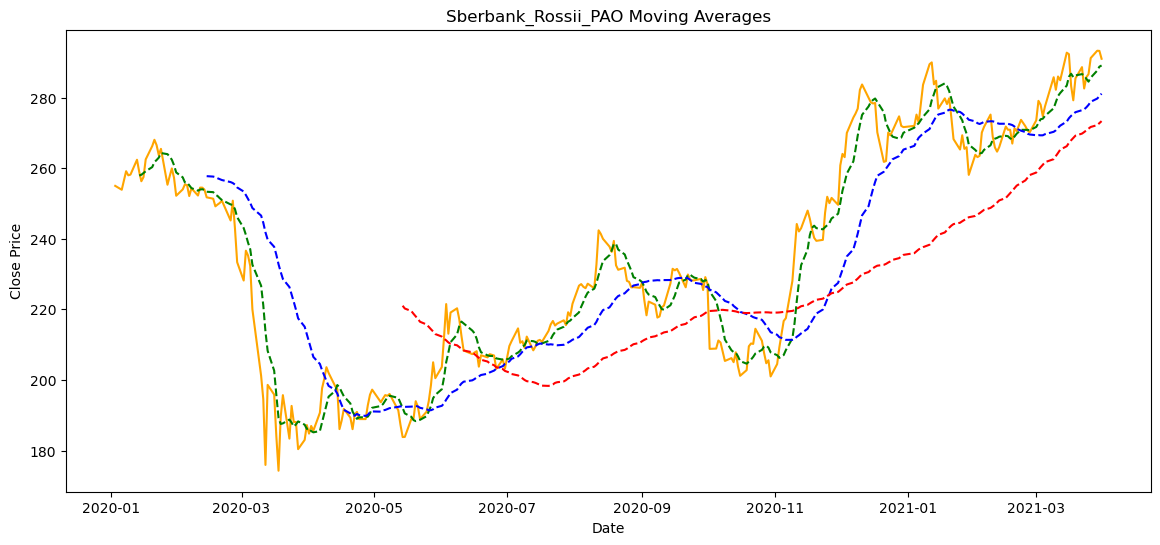

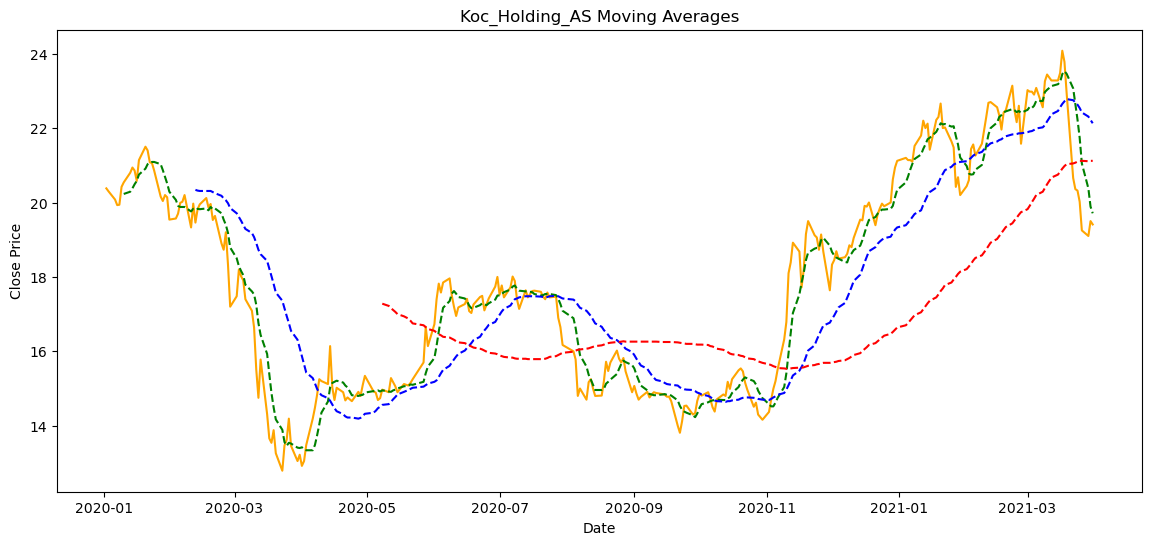

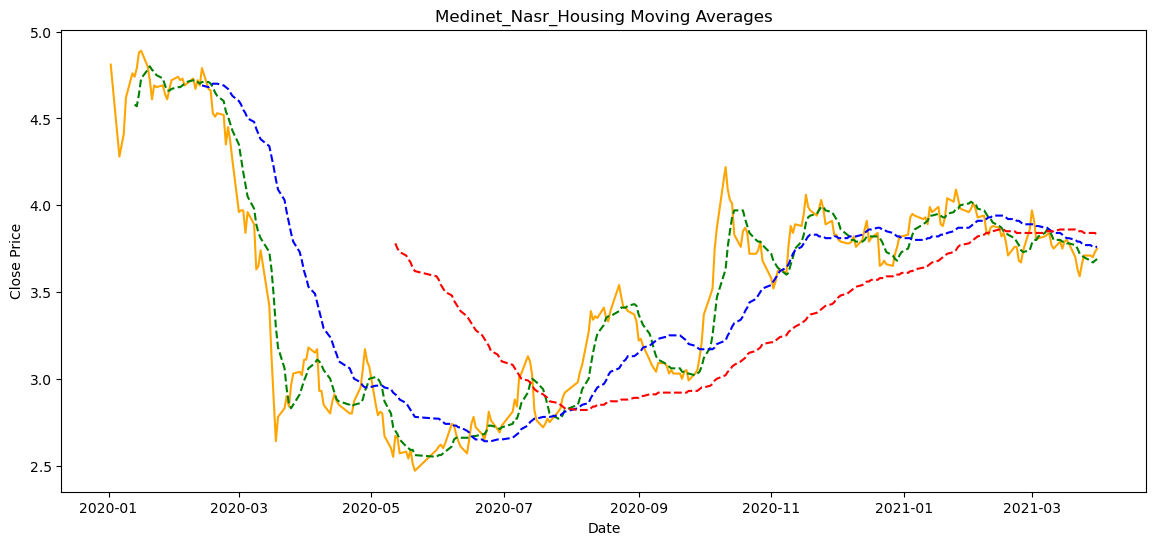

In [115]:
# Calculating and plotting curves for all the stocks. 

# Calculating and plotting Moving Avg. for first 3 stocks
Stocks=Consol_data['Stock'].unique()[:3]
All_MA_Data=pd.DataFrame()

for Stock in Stocks:
    MA_Data= Create_MA(Consol_data, Stock)
    All_MA_Data=pd.concat([All_MA_Data, MA_Data])
    Plot_MA(All_MA_Data, Stock)

# Exponential Moving Average

In [116]:
def Create_EMA(Raw_data, Stock, Span):
    EMA_Data=Raw_data[Raw_data['Stock']== Stock]
    EMA_Data=EMA_Data.loc[:,['Stock','Country','Date','Price']]
    EMA_Data=EMA_Data.sort_values(by='Date')

    span= Span
    alpha= 2/(span+1)
    
    model=SimpleExpSmoothing(EMA_Data['Price'].values)
    fit_model=model.fit(smoothing_level=alpha, optimized=False)
    EMA_Data['EWMA']=pd.Series(fit_model.fittedvalues).shift(-1)
    return EMA_Data

In [117]:
def Plot_EMA(EMA_Data, Stock):
    EMA_Data=EMA_Data[EMA_Data['Stock']== Stock]
    plt.figure(figsize=(14,6))
    plt.title(Stock+' '+'Exponential Moving Average')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.plot(EMA_Data['Date'],EMA_Data['Price'],color='orange')
    plt.plot(EMA_Data['Date'],EMA_Data['EWMA'],color='green',linestyle='--')

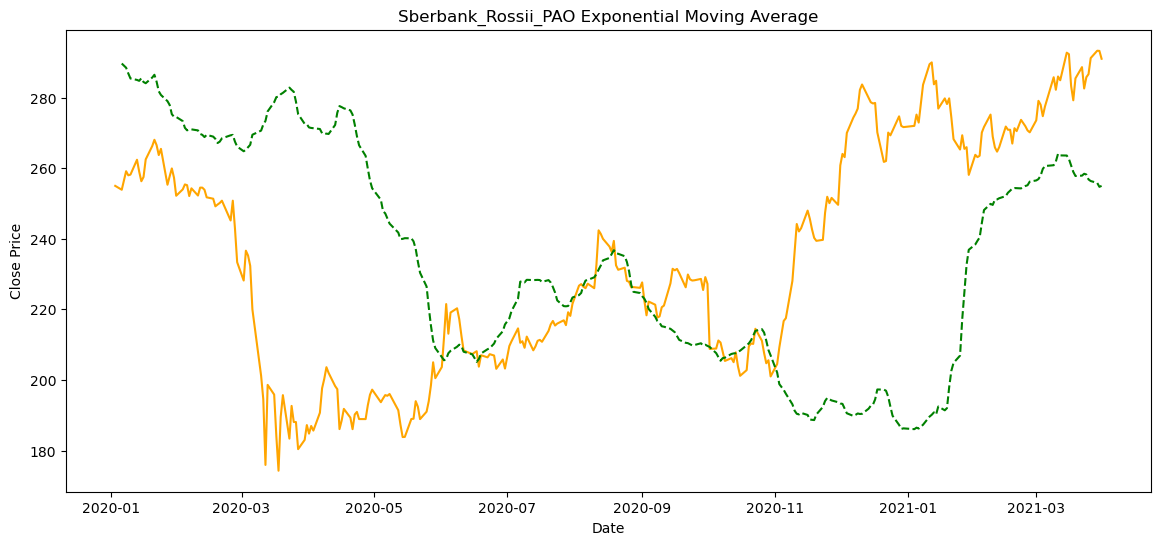

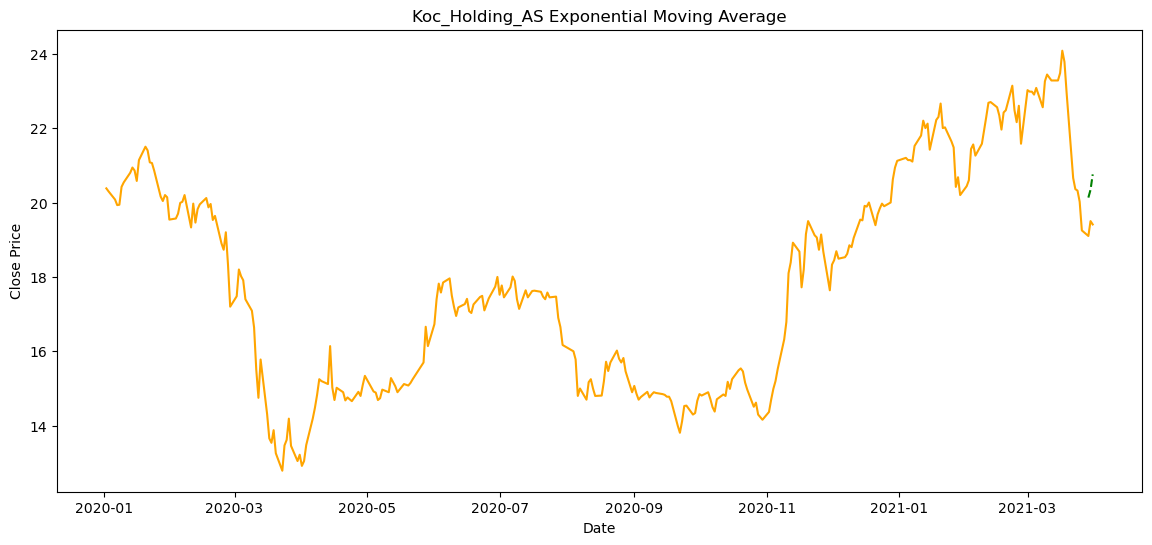

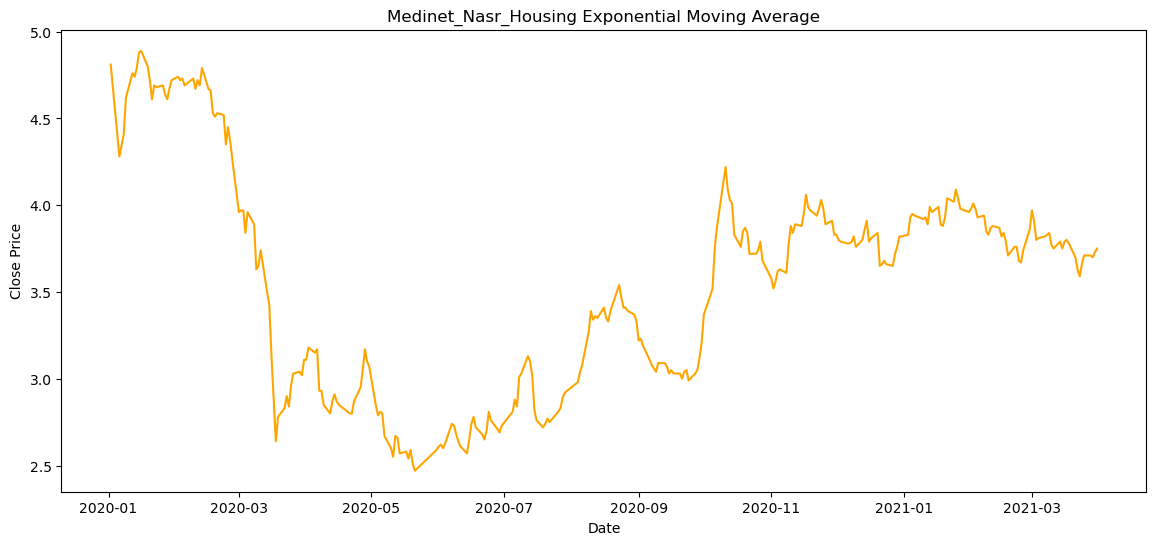

In [118]:
# Calculating and plotting curves for all the stocks. 

# Calculating and plotting Exponential Moving Avg. for first 3 stocks
Stocks=Consol_data['Stock'].unique()[:3]
All_EMA_Data=pd.DataFrame()

for Stock in Stocks:
    EMA_Data= Create_EMA(Consol_data, Stock,7)
    All_EMA_Data=pd.concat([All_EMA_Data, EMA_Data])
    Plot_EMA(All_EMA_Data, Stock)

# LSTM Model

In [120]:
# Defining the LSTM model architecture
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, input_shape=input_shape, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error',run_eagerly=True)
    return model

In [121]:
# Defining the LSTM split sequence
def split_sequence(sequence, n_steps):
    X, Y = [], []

    for i in range(len(sequence)):
        end_idx = i + n_steps
        if end_idx > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_idx], sequence[end_idx]
        X.append(seq_x)
        Y.append(seq_y)

    return np.array(X), np.array(Y)

In [122]:
def Train_LSTM(Raw_data, Stock, n_steps):
    # Filter data for the current country
    country_data = Raw_data[Raw_data['Stock'] == Stock]
        
    # Extract the price data for the current country
    price_data = country_data['Price'].values.astype(float)
        
    # Normalize the price data
    scaler = MinMaxScaler(feature_range=(0, 1))
    price_data_scaled = scaler.fit_transform(price_data.reshape(-1, 1))

    data_concat=pd.concat([country_data,pd.Series(price_data_scaled.reshape(-1))],axis=1)
        
    Train_data_scaled=data_concat[data_concat['Date']<='2020-12-31']
    Test_data_scaled=data_concat[data_concat['Date']>'2020-12-31']

    Train_price_scaled=Train_data_scaled.iloc[:,-1]
    Train_price_scaled=np.array(Train_price_scaled)

        
    # Split the sequence for the current country
    X_train_country, Y_train_country = split_sequence(Train_price_scaled, n_steps)

    # Reshape the input data
    X_train_country = X_train_country.reshape((X_train_country.shape[0], n_steps, 1))

    # Train the LSTM model
    model = create_lstm_model((X_train_country.shape[1], 1))
    model.fit(X_train_country, Y_train_country, epochs=10, batch_size=2, verbose=0)
    
    return Test_data_scaled, model, scaler, n_steps, Train_data_scaled

In [123]:
def Predict_LSTM(Test_data, model, scaler, n_steps):

    Test_price_scaled=Test_data.iloc[:,-1]
    Test_price_scaled=np.array(Test_price_scaled)

    X_test_country, Y_test_country = split_sequence(Test_price_scaled, n_steps)
    X_test_country = X_test_country.reshape((X_test_country.shape[0], n_steps, 1))

    test_predict= model.predict(X_test_country)
    test_predict= np.round(scaler.inverse_transform(test_predict))

    Predicted_data=Test_data.iloc[n_steps:,[0,1,2,-2]]
    Predicted_data['Test_predicted']=test_predict
    
    return Predicted_data

In [124]:
def Calculate_bands_and_plot(window_size,Train_data, test_and_predicted_data,Stock):

    Bband_data=pd.concat([Train_data,test_and_predicted_data])
    Bband_data=Bband_data.sort_values(by='Date',ascending=True)
    Bband_data=Bband_data.iloc[:,2:]
    Bband_data['Date']=[pd.to_datetime(date) for date in Bband_data['Date']]

    Bband_data['SMA']=np.round(Bband_data['Price'].rolling(window=window_size).mean(),2)
    Bband_data['STD']=np.round(Bband_data['Price'].rolling(window=window_size).std(),2)

    Bband_data['Upper_Band']=Bband_data['SMA']+(Bband_data['STD']*2)
    Bband_data['Lower_Band']=Bband_data['SMA']-(Bband_data['STD']*2)

    Bband_data['Stock']=Stock
    Bband_data.reset_index(drop='index',inplace=True)
    Bband_data=Bband_data[['Stock','Date','Price','Test_predicted','SMA','STD','Upper_Band','Lower_Band']]

    plt.figure(figsize=(14,6))
    plt.title(Stock)
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.plot(Bband_data['Date'],Bband_data['Price'])
    plt.plot(Bband_data['Date'],Bband_data['Test_predicted'])
    plt.plot(Bband_data['Date'],Bband_data['Upper_Band'], color='grey',linestyle='--')
    plt.plot(Bband_data['Date'],Bband_data['Lower_Band'], color='grey',linestyle='--')

    plt.fill_between(Bband_data['Date'],Bband_data['Upper_Band'],Bband_data['Lower_Band'],color='grey',alpha=0.2)
    plt.legend(Bband_data[['Price','Test_predicted','Upper_Band','Lower_Band']], loc='lower right')
    plt.show()
    
    return Bband_data

In [125]:
def implement_bb_strategy(predicted_data, Stock):

    buy_price = []
    sell_price = []
    bb_signal = []
    signal = 0

    predicted_data = predicted_data[predicted_data['Stock'] == Stock]
    predicted_data= predicted_data[predicted_data['Date']>'2020-11-30'].reset_index(drop='index')
    

    for i in range(0, len(predicted_data)):
        if i>0:
            if predicted_data['Test_predicted'][i] < predicted_data['Lower_Band'][i]:
                #predicted_data['Test_predicted'][i-1] > predicted_data['Lower_Band'][i-1] and 
                if signal != 1:
                    buy_price.append(predicted_data['Test_predicted'][i])
                    sell_price.append(np.nan)
                    signal = 1
                    bb_signal.append(signal)
                else:
                    buy_price.append(np.nan)
                    sell_price.append(np.nan)
                    bb_signal.append(0)
            
            elif predicted_data['Test_predicted'][i] > predicted_data['Upper_Band'][i]:
                #predicted_data['Test_predicted'][i-1] < predicted_data['Upper_Band'][i-1] and 
                if signal != -1:
                    sell_price.append(predicted_data['Test_predicted'][i])
                    buy_price.append(np.nan)
                    signal = -1
                    bb_signal.append(signal)
                else:
                    buy_price.append(np.nan)
                    sell_price.append(np.nan)
                    bb_signal.append(0) 
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)     
    
    strategy_output=pd.DataFrame({'Buy_Price':buy_price, 'Sell_Price': sell_price, 'BB_Signal':bb_signal}).reset_index(drop='index')
    strategy_output=pd.concat([predicted_data[['Date','Stock','Price','Test_predicted','Lower_Band','Upper_Band']],strategy_output],axis=1)

    return strategy_output

In [126]:
def plot_buy_sell_signals(strategy_data, Stock):
    plt.figure(figsize=(14,6))
    plt.plot(strategy_data['Date'],strategy_data['Price'])
    plt.plot(strategy_data['Date'],strategy_data['Test_predicted'])
    plt.plot(strategy_data['Date'],strategy_data['Upper_Band'], linestyle = '--', linewidth = 1, color = 'black')
    plt.plot(strategy_data['Date'],strategy_data['Lower_Band'], linestyle = '--', linewidth = 1, color = 'black')
    plt.fill_between(strategy_data['Date'],strategy_data['Upper_Band'],strategy_data['Lower_Band'],color='grey',alpha=0.2)

    plt.scatter( strategy_data['Date'], strategy_data['Buy_Price'], marker = '^', color = 'green', label = 'BUY', s = 200)
    plt.scatter( strategy_data['Date'], strategy_data['Sell_Price'], marker = 'v', color = 'red', label = 'SELL', s = 200)
    plt.title(Stock+' STRATEGY TRADING SIGNALS')
    plt.legend(loc = 'upper left')
    
    return plt.show()

In [127]:
# def Make_decision(Bband_data,Stock):
#     Bband_data = Bband_data[Bband_data['Stock'] == Stock]
#     Bband_data = Bband_data.copy()
#     Decision=[]
#     for index, row in Bband_data.iterrows():
#         if row['Test_predicted'] > row['Upper_Band']:
#             Decision.append("Sell")
#         elif row['Test_predicted'] < row['Lower_Band']:
#             Decision.append("Buy")
#         elif np.isnan(row['Test_predicted']):
#             Decision.append("N/A")    
#         else:
#             Decision.append("Hold")

#     Bband_data['Decision']= np.array(Decision)
#     #Bband_data.loc[:,'Decision']=np.array(Decision)
#     return Bband_data[['Stock','Date','Price','Test_predicted','Decision']]

In [128]:
def Calculate_Equity_Curve(All_Bband_data, Stock):
    Test_data_extract= All_Bband_data[All_Bband_data['Date']>'2020-12-31']
    Test_data_extract=Test_data_extract[Test_data_extract['Stock']==Stock]
    Test_data_extract['Position']=None
    Test_data_extract['Position'] = np.where(Test_data_extract['Test_predicted'] < Test_data_extract['Lower_Band'], 1, 0)
    Test_data_extract['Position'] = np.where(Test_data_extract['Test_predicted'] > Test_data_extract['Upper_Band'], -1, Test_data_extract['Position'])
    Test_data_extract['Returns'] = 1+(Test_data_extract['Test_predicted'].pct_change()*Test_data_extract['Position'].shift(1))
    Test_data_extract['Cumulative_Returns'] = Test_data_extract['Returns'].cumprod()

    #print("Test Set RMSE: ",np.round(math.sqrt(mean_squared_error(All_Country_Predicted['Price'],All_Country_Predicted['Test_predicted'])),3))
    Stock_MAPE=np.round(mean_absolute_percentage_error(Test_data_extract['Price'],Test_data_extract['Test_predicted'])*100,2)

    plt.plot(Test_data_extract['Date'],Test_data_extract['Cumulative_Returns'])
    plt.title(Stock+' '+'Equity Curve')
    plt.xlabel('Date')
    plt.ylabel('CumulativeReturns (%)')
    # Formatting the x-axis labels to show only day and month
    date_formatter = DateFormatter('%d-%m')  
    plt.gca().xaxis.set_major_formatter(date_formatter)  
    plt.show()

    print(Stock+' '+'MAPE:',Stock_MAPE,'%'), print('Cumulative return: ', np.round(Test_data_extract['Cumulative_Returns'].iloc[-1],2),'%')

    return  Test_data_extract

In [129]:
def Backtest_strategy(predicted_data, investment, Stock):
    # Initializing the necessary variables
    in_position = False  # Initially, we assume no shares are bought
    equity = investment  # Initial equity is the initial investment
    no_of_shares = 0  # Initially, no shares are held

    Test_data_extract=predicted_data[predicted_data['Stock']==Stock]


    # Initializing new columns for no_of_shares and equity
    predicted_data['no_of_shares'] = 0
    predicted_data['equity'] = investment  # Start with the initial investment

    for i in range(1, len(predicted_data)):
        if predicted_data['Test_predicted'][i-1] > predicted_data['Lower_Band'][i-1] and predicted_data['Test_predicted'][i] < predicted_data['Lower_Band'][i] and not in_position:
            # Buy signal
            no_of_shares = math.floor(equity / predicted_data.Test_predicted[i])
            equity -= (no_of_shares * predicted_data.Test_predicted[i])
            in_position = True
            print(f'BUY: {no_of_shares} shares bought at ${predicted_data.Test_predicted[i]} on {predicted_data.Date[i]}')

        elif predicted_data['Test_predicted'][i-1] < predicted_data['Upper_Band'][i-1] and predicted_data['Test_predicted'][i] > predicted_data['Upper_Band'][i] and in_position:
            # Sell signal
            equity += (no_of_shares * predicted_data.Test_predicted[i])
            no_of_shares = 0
            in_position = False
            print(f'SELL: Shares sold at ${predicted_data.Test_predicted[i]} on {predicted_data.Date[i]}')
            print(f'Updated equity: {equity}')

        # Updating the DataFrame with the current number of shares and equity
        predicted_data.at[i, 'no_of_shares'] = no_of_shares
        predicted_data.at[i, 'equity'] = equity

    # Closing any open position at the end
    if in_position:
        equity += (no_of_shares * predicted_data.Test_predicted.iloc[-1])
        print(f'\nClosing position at {predicted_data.Test_predicted.iloc[-1]} on {predicted_data.Date.iloc[-1]}')
        no_of_shares = 0  # No shares held after closing
        in_position = False
        print(f'Final equity: {equity}')
        # Updating the last row in the DataFrame
        predicted_data.at[len(predicted_data)-1, 'no_of_shares'] = no_of_shares
        predicted_data.at[len(predicted_data)-1, 'equity'] = equity

    earning = round(equity - investment, 2)
    roi = round(earning / investment * 100, 2)
    print(f'\nEARNING: ${earning} ; ROI: {roi}%')

    return predicted_data

2/2 [==============================] - 0s 42ms/step


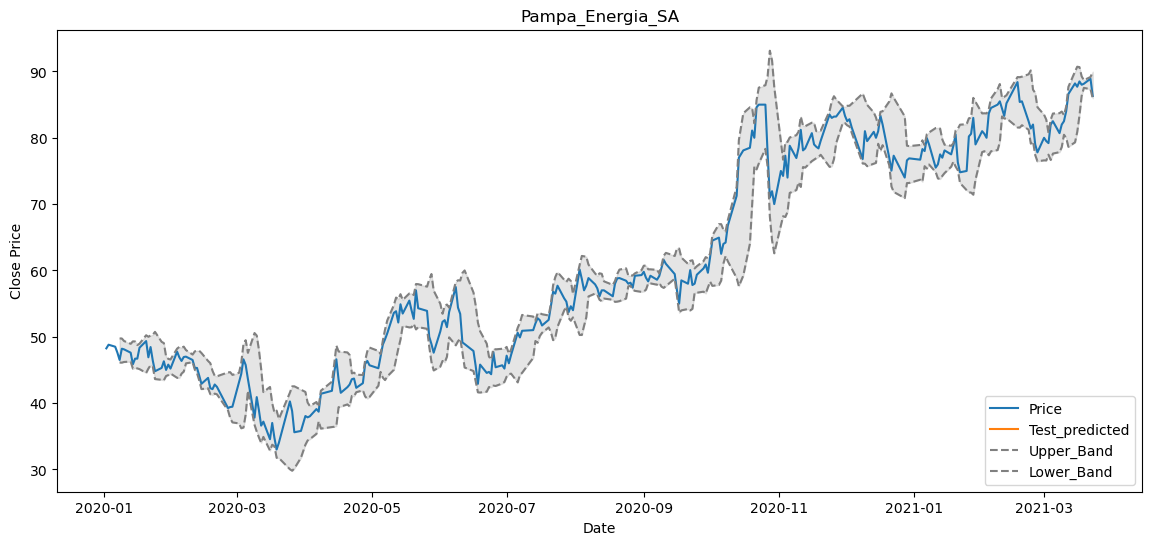

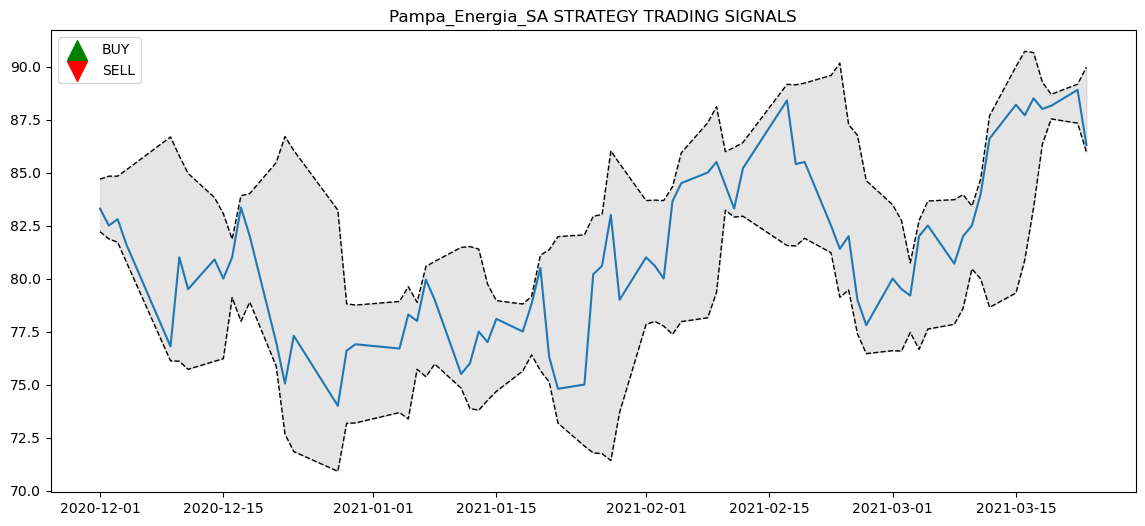


EARNING: $0 ; ROI: 0.0%


In [130]:
# Calculating and plotting curves for all the stocks. 

# Calculating and plotting LSTM model performance for first 3 stocks
Stocks=Consol_data['Stock'].unique()[4:5]
All_Bband_data= pd.DataFrame()
All_Strategy_Output=pd.DataFrame()

for Stock in Stocks:
    Test_data_scaled,  model, scaler, n_steps, Train_data_scaled = Train_LSTM(Consol_data, Stock,n_steps=5)
    
    Predicted_data = Predict_LSTM(Test_data_scaled,model,scaler,n_steps)
    
    Bband_data= Calculate_bands_and_plot(5,Train_data_scaled.iloc[:,[0,1,2,-2]],Predicted_data,Stock)

    All_Bband_data=pd.concat([All_Bband_data,Bband_data]).reset_index(drop='index')
    
    strategy_output= implement_bb_strategy(Bband_data,Stock)

    plot_buy_sell_signals(strategy_output, Stock)
    #print(Make_decision(All_Bband_data,Stock).tail())
    #Test_data_extract= Calculate_Equity_Curve(All_Bband_data, Stock)
    
    strategy_output= Backtest_strategy(strategy_output,100000, Stock)

    ll_Strategy_Output=pd.concat([All_Strategy_Output,strategy_output])


In the above strategy, we are making a one time investment of 100,000 and measuring its final return in terms of absolute value that is earnings and return on investment. It is to be noted that Bollinger Band strategy is one of the many strategies. There are many sophisticated strategies that enable higher frequency trading better suited for minimizing risks and optimizing profit. Given the size of the actual dataset (2 years worth data), I opted for a simpler trading strategy. 

The goal here was to evaluate forecasting methods such as LSTM v/s Prohphet and use backtesting strategy as a litmus test to evaluate forecasting performance. MAPE was used to measure the accuracy of the models with respect to actual prices. From above, we see that lower MAPE corresponded to higher accuracy in the forecasting with respect to actual stock prices. 

When considering a foercasting model, an ideal model should have lower MAPE and higher ROI. lower MAPE results and higher trade frequencies are evident when using LSTM compared to Prophet.

# Strategy #2

Using combination of Bollinger bands and RSI

In [131]:
def RSI(Bband_data, window_size):
    Bband_data=Bband_data[Bband_data['Date']>'2020-11-30'].reset_index(drop='index')
    delta=Bband_data['Test_predicted'].diff()
    gain= delta.where(delta>0,0)
    loss= delta.where(delta<0,0)
    avg_gain=gain.rolling(window=window_size).mean()
    avg_loss=loss.rolling(window=window_size).mean()

    RS=abs(avg_gain/avg_loss)
    RSI=np.round(100-(100/(1+RS)),2)

    Bband_data['RSI']=RSI
    Bband_data['Overbrought']=70
    Bband_data['Oversold']=30


    return Bband_data

In [132]:
def Strategy(data):
    position=0
    buy_price=[]
    sell_price=[]
    
    for i in range(len(data)):
        if data['Test_predicted'][i]<data['Lower_Band'][i] and data['RSI'][i]<data['Oversold'][i] and position==0:
            position=1
            buy_price.append(data['Test_predicted'][i])
            sell_price.append(np.nan)
        elif data['Test_predicted'][i]>data['Upper_Band'][i] and data['RSI'][i]>data['Overbrought'][i] and position==1: 
            position=0
            sell_price.append(data['Test_predicted'][i])
            buy_price.append(np.nan)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)

    Prices = pd.DataFrame({'Buy_Price':buy_price,'Sell_Price':sell_price})
    data= pd.concat([data,Prices],axis=1)
    return data         

In [133]:
Bband_data=RSI(Bband_data,14)
data=Strategy(Bband_data)
data.head()

,Stock,Date,Price,Test_predicted,SMA,STD,Upper_Band,Lower_Band,RSI,Overbrought,Oversold,Buy_Price,Sell_Price
0,Pampa_Energia_SA,2020-12-01,83.3,NaN,83.45,0.62,84.69,82.21,NaN,70,30,NaN,NaN
1,Pampa_Energia_SA,2020-12-02,82.5,NaN,83.35,0.74,84.83,81.87,NaN,70,30,NaN,NaN
2,Pampa_Energia_SA,2020-12-03,82.8,NaN,83.27,0.78,84.83,81.71,NaN,70,30,NaN,NaN
3,Pampa_Energia_SA,2020-12-04,81.6,NaN,82.95,1.09,85.13,80.77,NaN,70,30,NaN,NaN
4,Pampa_Energia_SA,2020-12-09,76.8,NaN,81.40,2.64,86.68,76.12,NaN,70,30,NaN,NaN


In [134]:
data['Buy_Price'].value_counts()

Series([], Name: count, dtype: int64)

# Facebook Prophet

In [135]:
Train_data=Consol_data[Consol_data['Date']<='2020-12-31']
Train_data_prohphet=Train_data.iloc[:,[0,1,2,-1]].sort_values(by='Date')
Train_data_prohphet=Train_data.rename(columns={'Date':'ds', 'Price':'y'})
Train_data_prohphet[['ds','y']]


,ds,y
61,2020-12-30,271.65
62,2020-12-29,272
63,2020-12-28,274.7
64,2020-12-25,270.64
65,2020-12-24,269.32
...,...,...
2493,2020-01-08,5430
2494,2020-01-07,5690
2495,2020-01-06,5730
2496,2020-01-03,5900


In [136]:
def Train_and_Predict_Prophet(Stock, Raw_data):
    
    country_data = Raw_data[Raw_data['Stock'] == Stock]
    Train_data=country_data[country_data['Date']<='2020-12-31']
    Test_data=country_data[country_data['Date']>'2020-12-31']
    
    Train_data= Train_data.iloc[:,[0,1,2,-1]].sort_values(by='Date')
    Train_data_prohphet=Train_data[['Date','Price']].rename(columns={'Date':'ds', 'Price':'y'})

    Test_data= Test_data.iloc[:,[0,1,2,-1]].sort_values(by='Date')
    Test_data_prohphet=Test_data[['Date','Price']].rename(columns={'Date':'ds', 'Price':'y'})


    model=Prophet(daily_seasonality=True)
    model.fit(Train_data_prohphet)
    #future=model.make_future_dataframe(periods=days_to_predict, freq='D',include_history=False)
    forecast=model.predict(Test_data_prohphet)


    forecast=forecast.rename(columns={'ds':'Date','yhat':'Test_predicted'})
    forecast=forecast[['Date','Test_predicted']]
    test_and_predicted_data=pd.merge(Test_data,forecast,on='Date')


    return Train_data, test_and_predicted_data, Train_data_prohphet

In [137]:
# Calculating and plotting curves for all the stocks. 

# Calculating and plotting Prophet Model performance for first 3 stocks
Stocks=Consol_data['Stock'].unique()[:3]
All_Prophet_Bband_data= pd.DataFrame()


for Stock in Stocks:    
    Train_data, test_and_predicted_data, Train_data_prohphet = Train_and_Predict_Prophet(Stock, Consol_data)
    Bband_data= Calculate_bands_and_plot(Train_data,test_and_predicted_data, Stock )
    All_Prophet_Bband_data=pd.concat([All_Prophet_Bband_data,Bband_data])
    print(Make_decision(All_Prophet_Bband_data,Stock).tail())
    Calculate_Equity_Curve(All_Prophet_Bband_data, Stock)
    

14:20:52 - cmdstanpy - INFO - Chain [1] start processing
14:20:52 - cmdstanpy - INFO - Chain [1] done processing


TypeError: Calculate_bands_and_plot() missing 1 required positional argument: 'Stock'

In [ ]:
Train_data
test_and_predicted_data


,Stock,Country,Date,Price,Test_predicted
0,Medinet_Nasr_Housing,Egypt,2021-01-03,3.83,3.980871
1,Medinet_Nasr_Housing,Egypt,2021-01-04,3.93,3.970977
2,Medinet_Nasr_Housing,Egypt,2021-01-05,3.95,3.998752
3,Medinet_Nasr_Housing,Egypt,2021-01-06,3.94,3.994834
4,Medinet_Nasr_Housing,Egypt,2021-01-10,3.92,4.017750
...,...,...,...,...,...
57,Medinet_Nasr_Housing,Egypt,2021-03-25,3.71,4.393228
58,Medinet_Nasr_Housing,Egypt,2021-03-28,3.71,4.423418
59,Medinet_Nasr_Housing,Egypt,2021-03-29,3.7,4.413524
60,Medinet_Nasr_Housing,Egypt,2021-03-30,3.73,4.441299
